# Basic Settings

In [1]:
from argparse import Namespace
import torch

args = Namespace(
    colab = False,
    # data and file paths
    url = "https://drive.google.com/u/0/uc?id=1Lmv4rsJiCWVs1nzs4ywA9YI-ADsTf6WB&export=download",
    csv_path = "../data/reviews_with_splits_lite.csv",
    
    ## vocab
    frequency_cutoff = 25,
    special_tkn = "<unk>",
    
    ## save
    model_state_file="model.pth",
    save_dir = "../models/yelp/",
    
    # training
    batch_size = 128,
    learning_rate=0.001,
    early_stopping_criteria = 5,
    num_epochs = 100,
    
    # runtime
    seed = 42,
    cuda = torch.cuda.is_available,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    expand_filepaths_to_save_dir = True
)

In [2]:
import string
import requests
from functools import partial
from collections import defaultdict
from pathlib import Path

# torch
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data.backward_compatibility import worker_init_fn
from torch.utils.data import (
    DataLoader,
    default_collate)

from torchtext import vocab
try:
    import torchdata.datapipes as dp
except:
    !pip install torchdata
    import torchdata.datapipes as dp
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics
    from torchmetrics import Accuracy

# manipulation
import numpy as np

# visualization
import matplotlib.pyplot as plt

# other
from tqdm import tqdm

try :
    import gdown
    from google.colab import drive
    args.colab = True

    # Paths
    DRIVE_PATH = Path("/content/drive")
    MODEL_SAVE_PATH = Path("/content/drive/Othercomputers/My PC/drive/models/yelp")
    args.save_dir = MODEL_SAVE_PATH
    Path("data").mkdir(parents=True,exist_ok=True)
    args.csv_path = "data/reviews_with_splits_lite.csv"

    # mount drive
    drive.mount(str(DRIVE_PATH))
except:
    pass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 74.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 15.2 MB/s eta 0:00:00
Mounted at /content/drive


In [3]:
args.colab

True

In [4]:
if args.colab:
    gdown.download(args.url,args.csv_path)

if args.expand_filepaths_to_save_dir:
    if not Path(args.save_dir).exists():
        Path(args.save_dir).mkdir(parents=True,exist_ok=True)
    args.model_state_file = Path(args.save_dir) / args.model_state_file
    print(args.model_state_file) 

Downloading...
From: https://drive.google.com/u/0/uc?id=1Lmv4rsJiCWVs1nzs4ywA9YI-ADsTf6WB&export=download
To: /content/data/reviews_with_splits_lite.csv
100%|██████████| 39.9M/39.9M [00:00<00:00, 44.7MB/s]


/content/drive/Othercomputers/My PC/drive/models/yelp/model.pth


# Data Pipe

In [5]:
def filter_fn(split,row):
    return row[2] == split

def split_classifier_fn(row):
    num = None
    if row[2] == "train":
        num = 0
    elif row[2] == "test":
        num = 2
    elif row[2] == "val":
        num = 1 
    return num


def review_token_fn(row):
    return [token 
            for token in row[1].split()
            if token not in string.punctuation]
        
def rating_token_fn(row):
    return [row[0]]

def create_dataset(review_vocab,rating_vocab,row):
    review_vector = np.zeros(shape=len(review_vocab),dtype=np.float32)
    review_vector[review_vocab.lookup_indices(review_token_fn(row))] = 1
    
    target = rating_vocab.lookup_indices([row[0]])[-1]
    
    return {"x":review_vector,
            "y":target}
    

In [6]:
args.colab

True

In [7]:
def build_vocab_and_build_dataset(args):
    
    # dict for return
    vocab_dict = defaultdict()
    dataset_dict = defaultdict()
    
    stream = dp.iter.FileOpener(dp.iter.IterableWrapper([args.csv_path]))
    row = stream.parse_csv(skip_lines=1)
    train_set,val_set,test_set = row.demux(num_instances=3,classifier_fn=split_classifier_fn,
                                           buffer_size=100000)
    
    # creating the review vocab
    review_token =  train_set.map(review_token_fn)
    review_vocab = vocab.build_vocab_from_iterator(review_token,min_freq=args.frequency_cutoff,
                                                   specials=[args.special_tkn])
    review_vocab.set_default_index(review_vocab[args.special_tkn])
    
    # creating the rating vocab
    rating_token = train_set.map(rating_token_fn)
    rating_vocab = vocab.build_vocab_from_iterator(rating_token)
    
    train_set = train_set.shuffle().sharding_filter()
    train_dataset = train_set.map(partial(create_dataset,review_vocab,rating_vocab))
    train_dataset = train_dataset.batch(batch_size=args.batch_size,drop_last=True)
    
    val_dataset = val_set.map(partial(create_dataset,review_vocab,rating_vocab))
    val_dataset = val_dataset.batch(batch_size=args.batch_size,drop_last=True)
    
    
    test_dataset = test_set.map(partial(create_dataset,review_vocab,rating_vocab))
    test_dataset = test_dataset.batch(batch_size=args.batch_size,drop_last=True)
    
    vocab_dict["review"] = review_vocab
    vocab_dict["rating"] = rating_vocab
    
    dataset_dict["train"] = train_dataset
    dataset_dict["val"] = val_dataset
    dataset_dict["test"] = test_dataset
    
    return vocab_dict , dataset_dict

In [8]:
vocab_dict , dataset_dict = build_vocab_and_build_dataset(args)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/datapipes/iter/combining.py:262: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [9]:
def generate_batches(dataset,batch_size,shuffle=False,device="cpu",
                     worker_init_fn=worker_init_fn):
    dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=shuffle,
                            worker_init_fn=worker_init_fn,
                            collate_fn=lambda x: {k:v.to(device).float() 
                                                      for x_ in default_collate(x)
                                                      for k,v in x_.items()})
    
    for batch in dataloader:
        yield batch

In [10]:
train_batch = generate_batches(dataset=dataset_dict["train"],
                               batch_size=args.batch_size,
                               shuffle=True,device=args.device)

# Model

In [11]:
class ReviewClassifier(nn.Module):
    def __init__(self,num_features) -> None:
        super().__init__()
        self.fc1 = nn.Linear(in_features=num_features,
                             out_features=1)
    
    def forward(self,input,apply_sigmoid=False):
        y_out = self.fc1(input).squeeze()
        if apply_sigmoid:
            y_out = F.sigmoid(y_out)
        return y_out

# Training routine

## setting and helper function

In [12]:
def make_train_state(args):
    return {"stop_early":False,
            "early_stopping_step":0,
            "early_stopping_best_val":1e8,
            "learning_rate":args.learning_rate,
            "model_filename":args.model_state_file,
            "epoch_index":0,
            "train_loss":[],
            "train_acc":[],
            "val_loss":[],
            "val_acc":[],
            "test_loss":-1,
            "test_acc":-1}

In [13]:
def update_train_state(train_state,args,model):
    # save one model at least
    if train_state["epoch_index"] == 0:
        torch.save(model.state_dict,train_state["model_filename"])
        train_state["stop_early"] = False
    
    # save model if it performed
    elif train_state["epoch_index"] >= 1:
        loss_tm1,loss_t = train_state["val_loss"][-2:]
        
        # it the loss worsen
        if loss_t >= train_state["early_stopping_best_val"]:
            train_state["early_stopping_step"] +=1
        
        # model is learning
        else:
            # save the model
            torch.save(model.state_dict(),train_state["model_filename"])
            train_state["early_stopping_step"] = 0
        
        train_state["stop_early"] = train_state["early_stopping_step"] >= args.early_stopping_criteria
        
    return train_state

In [14]:
def set_seed_everywhere(seed,cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)    
        
set_seed_everywhere(args.seed,args.cuda)

## loss,optimizer,accuracy,model

In [15]:
classifier = ReviewClassifier(len(vocab_dict["review"])).to(args.device)
loss_fn = nn.BCEWithLogitsLoss()
acc_fn = Accuracy(task="binary",num_classes=2).to(args.device)
optimizer = optim.Adam(params=classifier.parameters(),
                       lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode="min",
                                                 factor=0.5,patience=1)
train_state = make_train_state(args)

## training loop

In [16]:
for epoch_index in tqdm(range(args.num_epochs)):
    train_state["epoch_index"] = epoch_index
    
    # train step
    batch_generator = generate_batches(dataset_dict["train"],
                                       batch_size=args.batch_size,
                                       shuffle=True,
                                       device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()
    
    for batch_index,batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(batch_dict["x"])
        
        loss = loss_fn(y_pred,batch_dict["y"])
        loss_t = loss.item()
        running_loss += (loss_t -running_loss) / (batch_index +1)
        
        acc = acc_fn(y_pred,batch_dict["y"])
        acc_t = acc.item()
        running_acc += (acc_t - running_acc) / (batch_index+1)
        
        loss.backward()
        optimizer.step()
    
    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)
    
    
    # val step
    batch_generator = generate_batches(dataset=dataset_dict["val"],
                                       batch_size=args.batch_size,
                                       shuffle=False,
                                       device=args.device)
    
    running_loss = 0.0
    running_acc = 0.0
    classifier.eval()
    
    for batch_index,batch_dict in enumerate(batch_generator):
        with torch.inference_mode():
            y_pred  = classifier(batch_dict["x"])
            
            loss = loss_fn(y_pred,batch_dict["y"])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) /(batch_index+1)
            
            acc = acc_fn(y_pred,batch_dict["y"])
            acc_t = acc.item()
            running_acc += (acc_t - running_acc) / (batch_index+1)
    
    train_state["val_loss"].append(running_loss)
    train_state["val_acc"].append(running_acc)
       
    train_state = update_train_state(train_state,args,classifier)
    scheduler.step(train_state["val_loss"][-1])
    
    if train_state["stop_early"]:
        break

100%|██████████| 100/100 [10:57<00:00,  6.57s/it]


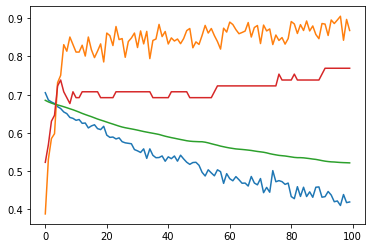

In [17]:
plt.plot(range(args.num_epochs),train_state["train_loss"])
plt.plot(range(args.num_epochs),train_state["train_acc"])
plt.plot(range(args.num_epochs),train_state["val_loss"])
plt.plot(range(args.num_epochs),train_state["val_acc"])
plt.show()

In [19]:
classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)


batch_generator = generate_batches(dataset_dict["test"], 
                                   batch_size=args.batch_size, 
                                   device=args.device,
                                   shuffle=False)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(batch_dict['x'])

    # compute the loss
    loss = loss_fn(y_pred, batch_dict['y'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = acc_fn(y_pred, batch_dict['y'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [21]:
print(f"{train_state['test_loss']:.3f}")
print(f"{train_state['test_acc']:.2%}")

0.439
86.15%
